In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.compose import ColumnTransformer

import cv2
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pandas as pd
from scipy.sparse import csr_matrix

import random
import time
import pickle
import h5py
from h5py import File

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50V2

##Read H5 files

In [ ]:
ftest=h5py.File("/content/drive/MyDrive/UITM/SEM 4/pickle file/1.3ktest.h5","r")
ftrain=h5py.File("/content/drive/MyDrive/UITM/SEM 4/pickle file/1.3ktrain.h5","r")

In [ ]:
print(ftest.keys())
print(ftrain.keys())

<KeysViewHDF5 ['test_x', 'test_y']>
<KeysViewHDF5 ['train_x', 'train_y']>


In [ ]:
train_x=ftrain.get('train_x')
train_y=ftrain.get('train_y')
test_x=ftest.get('test_x')
test_y=ftest.get('test_y')

In [ ]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [ ]:
print(test_x.shape)
print(test_y.shape)
print(train_x.shape)
print(train_y.shape)

(2765, 224, 224, 3)
(2765, 7)
(6449, 224, 224, 3)
(6449, 7)


##Optimizer


Adam & Adam-decay

In [ ]:
#decayed_lr = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000,decay_rate=0.9)
#opt = keras.optimizers.Adam(learning_rate=decayed_lr)
#opt='Adam'

SGD & SGD decay

In [ ]:
#opt = keras.optimizers.SGD(learning_rate=decayed_lr)
opt=keras.optimizers.SGD(learning_rate=0.01)

RMSprop

In [ ]:
#opt=keras.optimizers.RMSprop(learning_rate=decayed_lr)
#opt='RMSprop'

##Confusion Metrics

In [ ]:
cmetrics = [
    tf.keras.metrics.TruePositives(name = 'tp'), #correctly predicted cancer cell
    tf.keras.metrics.FalsePositives(name = 'fp'), #incorrectly predicted cancer cell
    tf.keras.metrics.TrueNegatives(name = 'tn'),# correctly predicted non cancerous
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.CategoricalAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc')
]

##Resnet50V2

In [ ]:
image_input=(224,224,3)
num_classes=7
EPOCH=50
BATCHSIZE=20
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50) #early stopping is used to improve training time and reduce overfitting

In [ ]:
# Import the Resnet library & add preprocessing layer to the front of resnet
# imagenet weights was use as Transfer learning
resnetv2 = ResNet50V2(input_shape=image_input, weights='imagenet', include_top=False)

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
# freeze top layers of models and train another half
for layer in resnetv2.layers[:]:
    layer.trainable = False

In [ ]:
# to avoid overfitting, dropout layer is added before fully conneted layers.
x = Flatten()(resnetv2.output)
x = Dropout(0.5)(x)  # dropout layer
out = Dense(num_classes, activation='softmax', name='output_layer')(x) #fully connected layer

In [ ]:
resnetv2TL = Model(inputs=resnetv2.input, outputs=out, name='ResNet50V2')

In [ ]:
resnetv2TL.summary()

Model: "ResNet50V2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
resnetv2TL.compile(loss='categorical_crossentropy',optimizer=opt, metrics=cmetrics)

In [ ]:
t1 = time.time()
modelfit_resnet = resnetv2TL.fit(train_x, train_y, epochs=EPOCH, batch_size=BATCHSIZE, verbose=2, validation_data=(test_x, test_y) 
                                 #callbacks=es
                                 )
# Testing has finished 
t2 = time.time()
print( 'Time taken was {} seconds'.format( t2 - t1))

Epoch 1/50
323/323 - 40s - loss: 31.5596 - tp: 3677.0000 - fp: 2765.0000 - tn: 35929.0000 - fn: 2772.0000 - accuracy: 0.5705 - precision: 0.5708 - recall: 0.5702 - auc: 0.7599 - val_loss: 42.5735 - val_tp: 1723.0000 - val_fp: 1042.0000 - val_tn: 15548.0000 - val_fn: 1042.0000 - val_accuracy: 0.6231 - val_precision: 0.6231 - val_recall: 0.6231 - val_auc: 0.7867
Epoch 2/50
323/323 - 27s - loss: 18.6172 - tp: 4556.0000 - fp: 1893.0000 - tn: 36801.0000 - fn: 1893.0000 - accuracy: 0.7065 - precision: 0.7065 - recall: 0.7065 - auc: 0.8382 - val_loss: 25.7242 - val_tp: 1780.0000 - val_fp: 985.0000 - val_tn: 15605.0000 - val_fn: 985.0000 - val_accuracy: 0.6438 - val_precision: 0.6438 - val_recall: 0.6438 - val_auc: 0.7998
Epoch 3/50
323/323 - 27s - loss: 13.8445 - tp: 4912.0000 - fp: 1535.0000 - tn: 37159.0000 - fn: 1537.0000 - accuracy: 0.7618 - precision: 0.7619 - recall: 0.7617 - auc: 0.8698 - val_loss: 55.4680 - val_tp: 1512.0000 - val_fp: 1253.0000 - val_tn: 15337.0000 - val_fn: 1253.0000

##Resnet50-V2 -Graph Performance

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


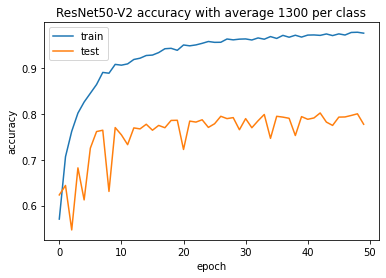

In [ ]:
print(modelfit_resnet.history.keys())
plt.plot(modelfit_resnet.history['accuracy'])
plt.plot(modelfit_resnet.history['val_accuracy'])
plt.title('ResNet50-V2 accuracy with average 1300 per class')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


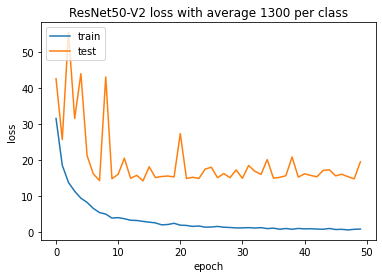

In [ ]:
print(modelfit_resnet.history.keys())
plt.plot(modelfit_resnet.history['loss'])
plt.plot(modelfit_resnet.history['val_loss'])
plt.title('ResNet50-V2 loss with average 1300 per class')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##InceptionV3

In [ ]:
image_input=(224,224,3)
num_classes=7
EPOCH=50
BATCHSIZE=20

In [ ]:
inceptionv3 = InceptionV3(input_shape=image_input, weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inceptionv3.layers[:]:
    layer.trainable = False

In [ ]:
x = Flatten()(inceptionv3.output)
x = Dropout(0.5)(x)
outIncv3 = Dense(num_classes, activation='softmax', name='output_layer')(x)
inceptionV3TL = Model(inputs=inceptionv3.input, outputs=outIncv3, name='InceptionV3')

In [ ]:
inceptionV3TL.summary()

Model: "InceptionV3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________________

In [ ]:
inceptionV3TL.compile(loss='categorical_crossentropy', optimizer=opt, metrics=cmetrics)

In [ ]:
import time

t1 = time.time()
inceptionV3TL_fit= inceptionV3TL.fit(train_x, train_y, epochs=EPOCH, batch_size=BATCHSIZE, verbose=2, validation_data=(test_x, test_y)
                                     #callbacks=es
                                     )
# Testing has finished 
t2 = time.time()
print( 'Time taken was {} seconds'.format( t2 - t1))

Epoch 1/50
323/323 - 30s - loss: 12.6207 - tp: 5508.0000 - fp: 3684.0000 - tn: 51600.0000 - fn: 3706.0000 - accuracy: 0.5982 - precision: 0.5992 - recall: 0.5978 - auc: 0.7881 - val_loss: 11.2284 - val_tp: 1550.0000 - val_fp: 1211.0000 - val_tn: 15379.0000 - val_fn: 1215.0000 - val_accuracy: 0.5609 - val_precision: 0.5614 - val_recall: 0.5606 - val_auc: 0.7641
Epoch 2/50
323/323 - 24s - loss: 5.7607 - tp: 4390.0000 - fp: 2048.0000 - tn: 36646.0000 - fn: 2059.0000 - accuracy: 0.6812 - precision: 0.6819 - recall: 0.6807 - auc: 0.8457 - val_loss: 8.0845 - val_tp: 1741.0000 - val_fp: 1017.0000 - val_tn: 15573.0000 - val_fn: 1024.0000 - val_accuracy: 0.6304 - val_precision: 0.6313 - val_recall: 0.6297 - val_auc: 0.8110
Epoch 3/50
323/323 - 23s - loss: 3.7435 - tp: 4885.0000 - fp: 1558.0000 - tn: 37136.0000 - fn: 1564.0000 - accuracy: 0.7579 - precision: 0.7582 - recall: 0.7575 - auc: 0.8906 - val_loss: 20.6575 - val_tp: 1124.0000 - val_fp: 1640.0000 - val_tn: 14950.0000 - val_fn: 1641.0000 

##Inception V3 -Graph Performance

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


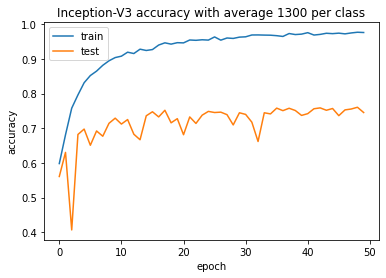

In [ ]:
print(inceptionV3TL_fit.history.keys())
plt.plot(inceptionV3TL_fit.history['accuracy'])
plt.plot(inceptionV3TL_fit.history['val_accuracy'])
plt.title('Inception-V3 accuracy with average 1300 per class')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


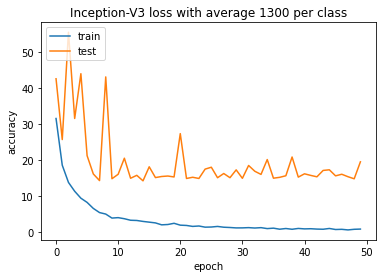

In [ ]:
print(inceptionV3TL_fit.history.keys())
plt.plot(modelfit_resnet.history['loss'])
plt.plot(modelfit_resnet.history['val_loss'])
plt.title('Inception-V3 loss with average 1300 per class')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Alexnet

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))
])

In [ ]:
weights_path='/content/drive/MyDrive/UITM/SEM 4/weight/alexnet_weights.h5'


def load_trained_model(weights_path):
   model = create_model()
   model.load_weights(weights_path)

In [ ]:
print("Freezed layers:")
for i, layer in enumerate(model.layers[:]):
    print(i, layer.name)
    layer.trainable = True

Freezed layers:
0 conv2d_94
1 batch_normalization_94
2 max_pooling2d_7
3 conv2d_95
4 batch_normalization_95
5 max_pooling2d_8
6 conv2d_96
7 batch_normalization_96
8 conv2d_97
9 batch_normalization_97
10 conv2d_98
11 batch_normalization_98
12 max_pooling2d_9


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_94 (Batc (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_95 (Batc (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 12, 12, 384)       8

In [ ]:
print("Freezed layers:")
for i, layer in enumerate(model.layers[:]):
    print(i, layer.name)
    layer.trainable = False

Freezed layers:
0 conv2d_94
1 batch_normalization_94
2 max_pooling2d_7
3 conv2d_95
4 batch_normalization_95
5 max_pooling2d_8
6 conv2d_96
7 batch_normalization_96
8 conv2d_97
9 batch_normalization_97
10 conv2d_98
11 batch_normalization_98
12 max_pooling2d_9


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_94 (Batc (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_95 (Batc (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 12, 12, 384)       8

In [ ]:
x = keras.layers.Flatten()(model.output)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

In [ ]:
out = keras.layers.Dense(7, activation='softmax')(x)

In [ ]:
alexout = Model(inputs=model.input, outputs=out, name='AlexNet')

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=cmetrics)

In [ ]:
alexout.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94_input (InputLayer) [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_94 (Batc (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_95 (Batc (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 256)       0   

In [ ]:
alexout.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=cmetrics)

In [ ]:
num_classes=7
EPOCH=50
BATCHSIZE=20

In [ ]:
t1 = time.time()
modelfit_alex = alexout.fit(train_x, train_y, epochs=EPOCH, batch_size=BATCHSIZE, verbose=2, validation_data=(test_x, test_y)
                                 #callbacks=es
                                 )
# Testing has finished 
t2 = time.time()
print( 'Time taken was {} seconds'.format( t2 - t1))

Epoch 1/50
323/323 - 9s - loss: 1.9382 - tp: 2061.0000 - fp: 703.0000 - tn: 54581.0000 - fn: 7153.0000 - accuracy: 0.3462 - precision: 0.7457 - recall: 0.2237 - auc: 0.7040 - val_loss: 1.9305 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 16590.0000 - val_fn: 2765.0000 - val_accuracy: 0.1949 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5639
Epoch 2/50
323/323 - 8s - loss: 1.9231 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 38694.0000 - fn: 6449.0000 - accuracy: 0.2301 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5863 - val_loss: 1.9145 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 16590.0000 - val_fn: 2765.0000 - val_accuracy: 0.1689 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5955
Epoch 3/50
323/323 - 8s - loss: 1.9083 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 38694.0000 - fn: 6449.0000 - accuracy: 0.2314 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6200 - val_loss: 1.8953 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_

##AlexNet-Graph Performance

In [ ]:
print(modelfit_alex.history.keys())
plt.plot(modelfit_alex.history['accuracy'])
plt.plot(modelfit_alex.history['val_accuracy'])
plt.title('AlexNet accuracy with average 1300 per class')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


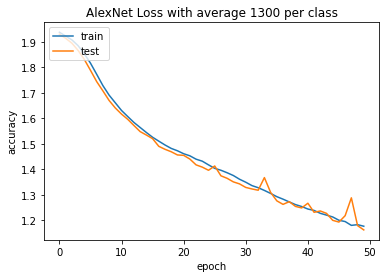

In [ ]:
print(modelfit_alex.history.keys())
plt.plot(modelfit_alex.history['loss'])
plt.plot(modelfit_alex.history['val_loss'])
plt.title('AlexNet Loss with average 1300 per class')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Save Model

In [ ]:
modelfit_resnet.save('/content/drive/MyDrive/UITM/SEM 4/pickle file')
inceptionV3TL_fit.save('/content/drive/MyDrive/UITM/SEM 4/pickle file')
modelfit_alex.save('/content/drive/MyDrive/UITM/SEM 4/pickle file')